# iLykei Lecture Series
# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Anomalies Detection using Autoencoders

## Notebook 4: Project Instructions

## Yuri Balasanov, Andrey Kobyshev, &copy; iLykei 2018-2021

This notebook describes the project      .

# Instructions on data preparation using simple example

The following few methods of data preparation will be useful in the project.  

If a model has been trained it can be used for prediction of a new set of data. In this case new data need to be prepared the same way as the train data were.

Consider a simple example of what we need to do in this case.

## Toy Train Dataset

Consider a toy data containing some information about cars. The response contains two classes. 

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import h5py
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
toyTrain = pd.DataFrame([['Cadillac', 'Red', 62391, 304, 1],
                          ['Cadillac', 'Blue', 2310, 213, 0], 
                          ['Ford', 'Red', 25391, 375, 0], 
                          ['Ford', 'Green', 12840, 160, 1]],
                         columns=['Brand', 'Color', 'Mileage','Horsepower','Class'])
toyTrain

,Brand,Color,Mileage,Horsepower,Class
0,Cadillac,Red,62391,304,1
1,Cadillac,Blue,2310,213,0
2,Ford,Red,25391,375,0
3,Ford,Green,12840,160,1


There are two categorical columns that represent Brand and Color.  

## One hot encoding

Transform character variables into numeric format using **one hot encoding** implemented in `pd.get_dummies()`.

In [4]:
toyTrain = pd.get_dummies(toyTrain, columns = ['Brand', 'Color'])
toyTrain

,Mileage,Horsepower,Class,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red
0,62391,304,1,1,0,0,0,1
1,2310,213,0,1,0,1,0,0
2,25391,375,0,0,1,0,0,1
3,12840,160,1,0,1,0,1,0


There are two "one hot" columns for **Brand** categories and three columns for **Color**.  
Create a list of features and make **"Class"** the last column.

In [5]:
featuresList = [col for col in toyTrain if col != 'Class']
print('featuresList: ',featuresList)
toyTrain = toyTrain[featuresList + ['Class']]
print('\nToy sample: \n')
toyTrain

featuresList:  ['Mileage', 'Horsepower', 'Brand_Cadillac', 'Brand_Ford', 'Color_Blue', 'Color_Green', 'Color_Red']

Toy sample: 



,Mileage,Horsepower,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red,Class
0,62391,304,1,0,0,0,1,1
1,2310,213,1,0,1,0,0,0
2,25391,375,0,1,0,0,1,0
3,12840,160,0,1,0,1,0,1


## Standardization 

Summaries of all variables are given by:

In [6]:
toyTrain.describe(percentiles=[])

,Mileage,Horsepower,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red,Class
count,4.000000,4.000000,4.00000,4.00000,4.00,4.00,4.00000,4.00000
mean,25733.000000,263.000000,0.50000,0.50000,0.25,0.25,0.50000,0.50000
std,26196.642953,95.453304,0.57735,0.57735,0.50,0.50,0.57735,0.57735
min,2310.000000,160.000000,0.00000,0.00000,0.00,0.00,0.00000,0.00000
50%,19115.500000,258.500000,0.50000,0.50000,0.00,0.00,0.50000,0.50000
max,62391.000000,375.000000,1.00000,1.00000,1.00,1.00,1.00000,1.00000


To standardize variables by z-scoring use `StandardScaler()`.

In [7]:
scaler = preprocessing.StandardScaler()
scaler.fit(toyTrain[featuresList]);

In [8]:
toyTrain[featuresList] = scaler.transform(toyTrain[featuresList])
toyTrain

,Mileage,Horsepower,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red,Class
0,1.615818,0.495978,1.0,-1.0,-0.577350,-0.577350,1.0,1
1,-1.032443,-0.604851,1.0,-1.0,1.732051,-0.577350,-1.0,0
2,-0.015075,1.354866,-1.0,1.0,-0.577350,-0.577350,1.0,0
3,-0.568300,-1.245993,-1.0,1.0,-0.577350,1.732051,-1.0,1


Check results of standardization.

In [9]:
print('Mean values:')
print(toyTrain[featuresList].mean())
print('\nStd values:')
print(toyTrain[featuresList].std(ddof=0))

Mean values:
Mileage          -2.775558e-17
Horsepower        5.551115e-17
Brand_Cadillac    0.000000e+00
Brand_Ford        0.000000e+00
Color_Blue       -5.551115e-17
Color_Green      -5.551115e-17
Color_Red         0.000000e+00
dtype: float64

Std values:
Mileage           1.0
Horsepower        1.0
Brand_Cadillac    1.0
Brand_Ford        1.0
Color_Blue        1.0
Color_Green       1.0
Color_Red         1.0
dtype: float64


Note that it is necessary to set `ddof=0` (delta degrees of freedom) because `sklearn.preprocessing.StandardScaler` uses `numpy.std()` with `ddof=0`.  
$std = \sqrt{\frac{\sum_{i=1}^{N}( x_{i}-\overset{\_}{x}) ^{2}}{%
N-ddof}}$  


## Preparing Test Dataset

Create test data manually.

In [10]:
toyTest = pd.DataFrame([['Cadillac', 'Black', 8332, 304, 1],
                          ['Chevrolet', 'Green', 3194, 355, 0]],
                         columns=['Brand', 'Color', 'Mileage','Horsepower','Class'])
toyTest

,Brand,Color,Mileage,Horsepower,Class
0,Cadillac,Black,8332,304,1
1,Chevrolet,Green,3194,355,0


To obtain prediction transform the test dataset the same way as the train dataset.

In [11]:
toyTest = pd.get_dummies(toyTest, columns = ['Brand', 'Color'])
toyTest

,Mileage,Horsepower,Class,Brand_Cadillac,Brand_Chevrolet,Color_Black,Color_Green
0,8332,304,1,1,0,1,0
1,3194,355,0,0,1,0,1


This creates a different set of "one hot" columns. 

To get the same set of columns add the missing columns of the train set with zero values and drop the extra columns that were not included in the train set.

In [12]:
missing_cols = set(toyTrain.columns) - set(toyTest.columns)
print('missing_cols: ',missing_cols)
for c in missing_cols:
    toyTest[c] = 0
toyTest = toyTest[toyTrain.columns].copy()
toyTest

missing_cols:  {'Color_Blue', 'Brand_Ford', 'Color_Red'}


,Mileage,Horsepower,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red,Class
0,8332,304,1,0,0,0,0,1
1,3194,355,0,0,0,1,0,0


Now use `scaler` that has been fit to the train dataset to transform the test dataset.

In [13]:
toyTest[featuresList] = scaler.transform(toyTest[featuresList])
toyTest

,Mileage,Horsepower,Brand_Cadillac,Brand_Ford,Color_Blue,Color_Green,Color_Red,Class
0,-0.767005,0.495978,1.0,-1.0,-0.57735,-0.577350,-1.0,1
1,-0.993478,1.112926,-1.0,-1.0,-0.57735,1.732051,-1.0,0


The test dataset is now ready for making predictions.

# Project data and step-by-step instructions

The goal of this project is to to detect illegitimate connections in a computer network using an **autoencoder** 

## Data set description

Data set for this project is from [The Third International Knowledge Discovery and Data Mining Tools Competition](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) at KDD-99, The Fifth International Conference on Knowledge Discovery and Data Mining. File `kddCupTrain.csv` with the data necessary for this project contains only one of multiple types of attacks (see below).  

The competition [task](http://kdd.ics.uci.edu/databases/kddcup99/task.html) was building a network intrusion detector capable of distinguishing "bad" connections, called intrusions or attacks, from "good" normal connections. This database contains a variety of intrusions simulated in a military network environment.

The original KDD training dataset consists of approximately 4,900,000 single connection vectors each of which contains 41 features and is labeled as either normal or an attack, with exactly one specific attack type. The simulated attacks fall in one of the following four categories:
1. Denial of Service Attack (DoS): is an attack in which the attacker makes some computing or memory resource too busy or too full to handle legitimate requests, or denies legitimate users access to a machine.
2. User to Root Attack (U2R): is a class in which the attacker starts out with access to a normal user account on the system (perhaps gained by sniffing passwords, a dictionary attack, or social engineering) and is able to exploit some vulnerability to gain root access to the system.
3. Remote to Local Attack (R2L): occurs when an attacker who has the ability to send packets to a machine over a network but who does not have an account on that machine exploits some vulnerability to gain local access as a user of that machine.
4. Probing Attack: is an attempt to gather information about a network of computers for the apparent purpose of circumventing its security controls.


Attacks contained in the dataset: 

Attack Category | Attack Type
--- | ---
DoS | back, land, neptune, <br>pod, smurf, teardrop
U2R | buffer_overflow, loadmodule, <br>perl, rootkit
R2L | ftp_write, guess_passwd, <br>imap, multihop, rhf, <br>spy, warezclient, warezmaster
Probe | portsweep, ipsweep, <br>satan, nmap


KDD-99 features can be classified into three groups:  
1) **Basic features**: this category encapsulates all the attributes that can be extracted from a TCP/IP connection. Most of these features leading to an implicit delay in detection.  
2) **Traffic features**: this category includes features that are computed with respect to a window interval and is divided into two groups:
* **"same host" features**: examine only the connections in the past 2 seconds that have the same destination host as the current connection, and calculate statistics related to protocol behavior, service, etc.
* **"same service" features**: examine only the connections in the past 2 seconds that have the same service as the current connection.  

These two types of "traffic" features are called time-based as opposed to the following connection-based type. 

* **"connection-based" features**: there are several types of slow probing attacks that scan the hosts (or ports) using a much larger time interval than 2 seconds, for example, one in every minute. As a result, these attacks do not produce intrusion patterns with a time window of 2 seconds. To detect such attacks the “same host” and “same service” features are  recalculated but based on the connection window of 100 connections rather than a time window of 2 seconds. These features are called **connection-based traffic features**.  

3) **Content features**: unlike most of the DoS and Probing attacks, the R2L and U2R attacks don’t have any frequent sequential intrusion patterns. This is because the DoS and Probing attacks involve many connections to some host(s) in a very short period of time. Unlike them, the R2L and U2R attacks are embedded in the data portions of the packets, and normally involve only a single connection. To detect these kinds of attacks, one needs some features in order to look for suspicious behavior in the data portion, e.g., number of failed login attempts. These features are called **content features**.

#### Table 1: Basic features of individual TCP connections.
nn | feature name |	description |	type
--:|------------|-----------|-----------
0 | duration | length (number of seconds) of the connection |	continuous
1 | protocol_type |	type of the protocol, e.g. tcp, udp, etc. |	symbolic
2 | service |	network service on the destination, e.g., http, telnet, etc. |	symbolic
3 | flag |	normal or error status of the connection |	symbolic 
4 | src_bytes |	number of data bytes from source to destination |	continuous
5 | dst_bytes |	number of data bytes from destination to source |	continuous
6 | land |	1 if connection is from/to the same host/port; 0 otherwise |	binary
7 | wrong_fragment |	number of "wrong" fragments |	continuous
8 | urgent |	number of urgent packets |	continuous

#### Table 2: Content features within a connection suggested by domain knowledge.
nn | feature name |	description |	type
---:|------------ | ------------ | --------
9 | hot |	number of "hot" indicators |	continuous
10 | num_failed_logins |	number of failed login attempts |	continuous
11 | logged_in |	1 if successfully logged in; 0 otherwise |	binary
12 | num_compromised |	number of "compromised" conditions |	continuous
13 | root_shell |	1 if root shell is obtained; 0 otherwise |	binary
14 | su_attempted |	1 if "su root" command attempted; 0 otherwise |	binary
15 | num_root |	number of "root" accesses |	continuous
16 | num_file_creations |	number of file creation operations |	continuous
17 | num_shells |	number of shell prompts |	continuous
18 | num_access_files |	number of operations on access control files |	continuous
19 | num_outbound_cmds |	number of outbound commands in an ftp session |	continuous
20 | is_hot_login |	1 if the login belongs to the "hot" list; 0 otherwise |	binary
21 | is_guest_login |	1 if the login is a "guest" login; 0 otherwise |	binary

#### Table 3: Traffic features computed using a two-second time window.
nn  | feature name |	description |	type
---:|------------ | ------------ | --------
22 | count |	number of connections to the same host as the current connection in the past two seconds |	continuous
 | | Note: The following  features refer to these same-host connections.	|
23 | serror_rate |	% of connections that have "SYN" errors |	continuous
24 | rerror_rate |	% of connections that have "REJ" errors |	continuous
25 | same_srv_rate |	% of connections to the same service |	continuous
26 | diff_srv_rate |	% of connections to different services |	continuous
27 | srv_count |	number of connections to the same service as the current connection in the past two seconds |	continuous
 |  | Note: The following features refer to these same-service connections.	|
28 | srv_serror_rate |	% of connections that have "SYN" errors |	continuous
29 | srv_rerror_rate |	% of connections that have "REJ" errors |	continuous
30 | srv_diff_host_rate |	% of connections to different hosts |	continuous
31 | dst_host_count |	number of connections from the same address to the same host as the current connection in the past two seconds |	continuous
32 | dst_host_srv_count | number of connections from the same host to the same service as the current connection in the past two seconds | continuous
 |  | Note: The following features refer to these same-host and same-service connections.	|
33 | dst_host_same_srv_rate | |	continuous
34 | dst_host_diff_srv_rate | |	continuous
35 | dst_host_same_src_port_rate | |	continuous
36 | dst_host_srv_diff_host_rate | |	continuous
37 | dst_host_serror_rate | |	continuous
38 | dst_host_srv_serror_rate | |	continuous
39 | dst_host_rerror_rate | |	continuous
40 | dst_host_srv_rerror_rate | |	continuous

The attribute labeled **41** in the data set is the **"Class"** attribute which indicates whether a given instance is a normal connection instance or an attack.

## Project instructions

### 1. Preparing the data

#### 1.1. Reading data

Read the train dataset  `kddCupTrain.csv` from `kddCupData.zip` and check it for missing values.

In [14]:
kddCupTrain = pd.read_csv('kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   10  11  12  13  14  15  16  \
0   0  tcp  http  SF  215  45076   0   0   0   0   0   1   0   0   0   0   0   
1   0  tcp  http  SF  162   4528   0   0   0   0   0   1   0   0   0   0   0   
2   0  tcp  http  SF  236   1228   0   0   0   0   0   1   0   0   0   0   0   

   17  18  19  20  21  22  23   24   25   26   27   28   29   30  31  32   33  \
0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   0   0  0.0   
1   0   0   0   0   0   2   2  0.0  0.0  0.0  0.0  1.0  0.0  0.0   1   1  1.0   
2   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0   2   2  1.0   

    34   35   36   37   38   39   40       41  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  normal.  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.5  0.0  0.0  0.0  0.0  0.0  normal.  


The train dataset contains instances of only two class types from the [original](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data: 
- "normal." - no attack
- "ipsweep." - a subtype of "probe" or Probing Attack type.  

In [15]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

Rename column '41' to 'Class' and transform its values from symbolic type fo binary:  
- "normal." to 0  
- "ipsweep." to 1

In [16]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

Check counts of classes.

In [17]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


The dataset is highly imbalanced. Normal connections overwhelmingly outnumber fraudulent ones. 
This suggests using an autoencoder to detect attacks as rare deviations from normal.

#### 1.2. Remove the uninformative columns

Look at summaries of numeric features.

In [18]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6         7  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000  985262.0   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007       0.0   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665       0.0   
min         0.000000  0.000000e+00  0.000000e+00       0.000000       0.0   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000       0.0   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000       0.0   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.00

  
#### 1.3. Transform symbolic features to "One Hot" columns

Transform character features "1", "2" and "3" into "One Hot" columns using `pandas.get_dummies()` as shown in the section above. 

As a result, the first two rows of `kddCupTrain` should look like this:  

|  0  |  4  |    5 | 6 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 20 | 21 | 22 | 23   
--|--
0 | 0 | 215 | 45076 | 0 | 0 | 0 |  0 |  1 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  0 |  1 | 1   
1 | 0 | 162 | 4528 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 2 | 2   

| 24 | 25 | 26 | 27 |  28 |  29  | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38
--|--
0|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  0 |  0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0 | 0.0   
1|0.0 | 0.0 | 0.0 | 0.0 | 1.0 | 0.0 | 0.0 |  1 |  1 | 1.0 | 0.0 | 1.0 | 0.0 | 0.0 | 0.0   

  | 39 | 40 | Class | 1_icmp | 1_tcp | 1_udp | 2_IRC | 2_X11 | 2_auth | 2_ctf
--|--
0 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   
1 | 0.0 | 0.0 | 0 | 0 | 1 | 0 |  0  |    0  |     0  |    0   

 | 2_domain | 2_domain_u | 2_eco_i | 2_ecr_i | 2_finger | 2_ftp | 2_ftp_data
 --|--
0  |   0  |    0  |   0  |  0  |   0  |    0   |   0   
1  |   0  |    0  |   0  |  0  |   0  |    0   |   0   

| 2_gopher | 2_http | 2_imap4 | 2_link | 2_mtp | 2_name | 2_ntp_u | 2_other 
--|--
0 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   
1 |   0  |     1   |     0  |     0  |    0  |     0  |      0   |     0   

| 2_pop_3 | 2_private | 2_red_i | 2_remote_job | 2_rje | 2_shell | 2_smtp | 2_ssh 
--|--
0 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   
1 |       0 |         0 |       0 |            0 |     0 |       0 |      0 |     0   

| 2_telnet | 2_tftp_u | 2_tim_i | 2_time | 2_urh_i | 2_urp_i | 2_whois | 3_OTH  
--|--
0 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   
1 |        0 |     0 |       0 |      0 |       0 |       0 |       0 |     0   

| 3_REJ | 3_RSTO | 3_RSTR | 3_S0 | 3_S1 | 3_S2 | 3_S3 | 3_SF | 3_SH  
--|--
0 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  
1 |     0 |      0 |      0 |    0 |    0 |    0 |    0 |    1 |    0  

In [19]:
kddCupTrain.drop([7,19], axis=1, inplace=True)

In [20]:
#code
kddCupTrain =\
pd.get_dummies(kddCupTrain, columns = [1, 2, 3])
kddCupTrain.head(3)

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,236,1228,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
kddCupTrain.shape

(985262, 84)

After removing uninformative variables and replacing character variables with hot encoding the dataset contains 83 numeric features.

#### 1.4. Standardize the training dataset

Create a list of features, standardize the features columns using `sklearn.preprocessing.StandardScaler`.

**Further steps are similar to those covered in the notebook `MScA_32017_AMLAI_AE3_FraudDetection.ipynb`.**

In [22]:
from sklearn.preprocessing import StandardScaler
kddCupTrain.dtypes

0                 int64
4                 int64
5                 int64
6                 int64
8                 int64
9                 int64
10                int64
11                int64
12                int64
13                int64
14                int64
15                int64
16                int64
17                int64
18                int64
20                int64
21                int64
22                int64
23                int64
24              float64
25              float64
26              float64
27              float64
28              float64
29              float64
30              float64
31                int64
32                int64
33              float64
34              float64
35              float64
36              float64
37              float64
38              float64
39              float64
40              float64
Class             int32
1_icmp            uint8
1_tcp             uint8
1_udp             uint8
2_IRC             uint8
2_X11           

In [23]:
#select data types
clst = kddCupTrain.drop('Class', axis=1).select_dtypes(['int64', 'float']).columns

sclr = StandardScaler()

for i in clst:
    kddCupTrain[i] = sclr.fit_transform(kddCupTrain[i].values.reshape(-1, 1))



In [24]:
sclr

StandardScaler()

In [25]:
kddCupTrain.describe()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
count,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,9.852620e+05,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.00000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000,985262.00000,985262.000000,985262.000000,985262.000000,985262.000000,985262.000000
mean,-3.902105e-13,2.406711e-15,1.810352e-14,-3.451193e-14,-7.015802e-15,4.911297e-14,4.875149e-15,4.645983e-12,-1.404987e-15,1.027645e-13,3.398800e-14,-1.289336e-14,1.256161e-14,6.611076e-14,-8.125271e-14,-2.224469e-15,-2.329870e-14,-1.583833e-13,1.341082e-13,-7.842140e-14,1.218339e-13,1.138495e-12,-7.429875e-13,1.145431e-12,-5.408599e-13,2.850148e-14,-9.426963e-13,-4.444883e-13,1.611694e-13,-1.219637e-12,4.962446e-13,3.988968e-13,1.790377e-13,3.115870e-14,9.669891e-13,-8.685212e-13,0.012668,0.024684,0.781106,0.194210,0.000528,0.000131,0.002363,0.000013,0.000052,0.058637,0.015514,0.003548,0.005105,0.003891,0.038676,0.000013,0.628319,0.000003,0.000013,0.000013,0.000013,0.003890,0.057365,0.000936,0.07567,0.000009,0.000013,0.000013,0.000005,0.096811,0.000020,0.002275,0.000003,0.000007,0.000530,0.000150,0.005455,0.000013,0.000013,0.055108,0.000646,0.000339,0.00043,0.000536,0.000155,0.000047,0.942724,0.000002
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.111836,0.155160,0.413497,0.395592,0.022967,0.011442,0.048551,0.003632,0.007194,0.234945,0.123584,0.059462,0.071268,0.062259,0.192822,0.003632,0.483254,0.001745,0.003632,0.003632,0.003632,0.062251,0.232540,0.030576,0.26447,0.003022,0.003632,0.003632,0.002253,0.295700,0.004505,0.047638,0.001745,0.002665,0.023011,0.012255,0.073659,0.003632,0.003632,0.228191,0.025399,0.018409,0.02074,0.023143,0.012461,0.006833,0.232370,0.001425
min,-1.600725e-01,-1.329034e-02,-9.388875e-02,-2.665476e-03,-2.234568e-03,-5.281577e-02,-7.461958e-03,-1.565399e+00,-4.408477e-03,-1.751032e-02,-1.009727e-02,-7.306233e-03,-2.114431e-02,-1.882529e-02,-6.414992e-02,-1.424753e-03,-6.202602e-02,-4.569393e-01,-5.056220e-01,-5.417737e-02,-6.537940e-02,-2.446383e-01,-2.471001e-01,-1.065986e+01,-1.567002e-01,-4.866738e-01,-1.409932e+00,-2.305156e+00,-2.774254e+00,-3.127681e-01,-4.906011e-01,-3.649280e-01,-7.100494e-02,-6.765907e-02,-2.569938e-01,-2.556993e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

#### 1.5. Split the data into train and test subsets 

Use `sklearn.model_selection.train_test_split()` function. Reserve 20% of data for the test data. Do not forget to set the parameter `stratify` to keep the class size ratio within each of data sets.

In [26]:
from sklearn.model_selection import train_test_split

X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2,
                                   stratify=kddCupTrain['Class'], 
                                   random_state=44)

#### 1.6. Detach the labels from the train and the test datasets

In [27]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)

In [28]:
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 83) , shape Y (788209,)
Test: shape X (197053, 83) , shape Y (197053,)


In [29]:
y_train.value_counts()

0    778224
1      9985
Name: Class, dtype: int64

#### 1.7. Separate the "normal" instances

An autoencoder will be trained to reconstruct class "normal". Separate the "normal" instances in both `train` and `test` datasets.

In [30]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axis labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [31]:
print(y_train.shape)
print(X_train.shape)

(788209,)
(788209, 83)


In [32]:
X_trainNorm_val.shape

(778224, 83)

### 2. Build the model


#### 2.1. select architecture of autoencoder

Try different numbers and dimentions of layers. Use `BatchNormalization` and `Dropout` layers to achieve better results.

In [33]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 40 #28
encoder_dim = 20 #7

In [34]:
#create tensors
input_layer = Input(shape=(input_dim, ))

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder2 = Dense(encoder_dim, activation="relu")(encoder1)
decoder1 = Dense(layer1_dim, activation='tanh')(encoder2)
decoder2 = Dense(input_dim, activation='linear')(decoder1)
print('input_layer: ',input_layer)
print('encoder1',encoder1)
print('encoder2',encoder2)
print('decoder1',decoder1)
print('decoder2',decoder2)

input_layer:  KerasTensor(type_spec=TensorSpec(shape=(None, 83), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
encoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='dense/Tanh:0', description="created by layer 'dense'")
encoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense_1/Relu:0', description="created by layer 'dense_1'")
decoder1 KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='dense_2/Tanh:0', description="created by layer 'dense_2'")
decoder2 KerasTensor(type_spec=TensorSpec(shape=(None, 83), dtype=tf.float32, name=None), name='dense_3/BiasAdd:0', description="created by layer 'dense_3'")


In [35]:
autoencoder = Model(inputs=input_layer, outputs=decoder2)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 83)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 83)                3403      
Total params: 8,423
Trainable params: 8,423
Non-trainable params: 0
_________________________________________________________________


#### 2.2. Fit the model

Fit autoencoder to the "normal" instances of the train dataset.  
Use `ModelCheckpoint` callback to save the best model to file:

`checkpointer = ModelCheckpoint(filepath="autoencoder.h5",
                               verbose=0,
                               save_best_only=True)`    

In [36]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="autoenc_model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               earlystopping]).history

Epoch 1/100
24320/24320 [==============================] - 65s 3ms/step - loss: 0.2009 - val_loss: 0.0670
Epoch 2/100
24320/24320 [==============================] - 65s 3ms/step - loss: 0.1403 - val_loss: 0.0528
Epoch 3/100
24320/24320 [==============================] - 73s 3ms/step - loss: 0.1276 - val_loss: 0.0459
Epoch 4/100
24320/24320 [==============================] - 68s 3ms/step - loss: 0.0924 - val_loss: 0.0412
Epoch 5/100
24320/24320 [==============================] - 67s 3ms/step - loss: 0.1378 - val_loss: 0.0382
Epoch 6/100
24320/24320 [==============================] - 59s 2ms/step - loss: 0.1177 - val_loss: 0.0387


                               
### 3. Evaluation

#### 3.1. Load the fitted autoencoder from file `"autoencoder.h5"`.

In [1]:
#don't need to, in the first run

#### 3.2.  Reconstruction

Reconstruct the **test** dataset using the fitted autoencoder, calculate the **mean squared error** of the prediction.  

In [38]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((197053, 83), (197053, 83))

#### 3.3. Evaluate

Calculate MSE of each observation by averaging squared errors of reconstruction of all features in a row.  

In [39]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
642603,0.001174,0
714860,0.014548,0
279733,0.002844,0
675259,0.010625,0
954057,0.001106,0


In [40]:
error_df.reconstruction_error.describe()

count    197053.000000
mean          0.039637
std           4.515713
min           0.000573
25%           0.001219
50%           0.001997
75%           0.005626
max        1681.521576
Name: reconstruction_error, dtype: float64

#### 3.3.1 Comparison Plots

Let's look at the reconstruction for the normal vs reconstruction for the problematic.

**Normal**

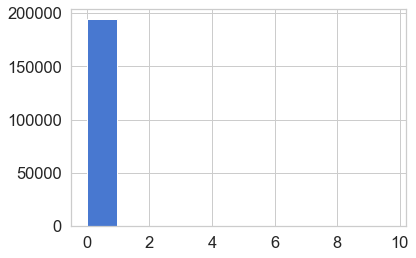

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

**Problematic**

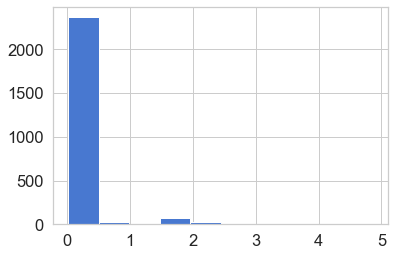

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

#### 3.3.2 Metrics

Calculate ROC and AUC. Select appropriate quantile and calculate Accuracy and Cohen's Kappa.

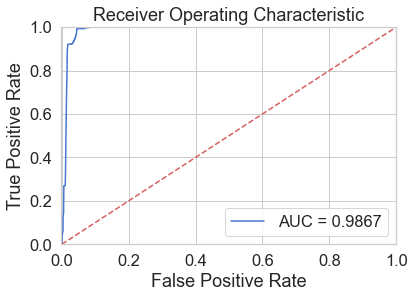

In [43]:
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### 4.Create submission

#### 4.1. Read test data

Read the **test** dataset from ['kddCupTest.csv'](kddCupTest.csv) and check it for missing values.  

In [45]:
kddCupTest = pd.read_csv('kddCupTest.csv', header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp     http  SF   230  10066   0   0   0   0   0   1   0   0   0   0   
1   0  udp  private  SF   105    145   0   0   0   0   0   0   0   0   0   0   
2   1  tcp     smtp  SF  1888    374   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29   30   31  \
0   0   0   0   0   0   0  19  20  0.0  0.0  0.0  0.0  1.0  0.0  0.1  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   
2   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   

    32    33    34   35   36   37   38   39   40  
0  255  1.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  227  0.89  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  174  0.68  0.03  0.0  0.0  0.0  0.0  0.0  0.0  


Notice that there are no lables in the test dataset. The features columns are the same.

#### 4.2. Do "One hot" transformation of categorical features

Don't forget to make the features list exactly the same as in the **train** dataset.  

In [46]:
kddCupTest.drop([7,19], axis=1, inplace=True)
kddCupTest =\
pd.get_dummies(kddCupTest, columns = [1, 2, 3])
kddCupTest.head(3)

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_Z39_50,2_auth,2_bgp,2_csnet_ns,2_ctf,2_daytime,2_discard,2_domain,2_domain_u,...,2_gopher,2_harvest,2_hostnames,2_http,2_http_2784,2_imap4,2_iso_tsap,2_link,2_mtp,2_name,2_netbios_dgm,2_netbios_ns,2_netbios_ssn,2_netstat,2_nntp,2_ntp_u,2_other,2_pm_dump,2_pop_2,2_pop_3,2_printer,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_sql_net,2_ssh,2_sunrpc,2_supdup,2_systat,2_telnet,2_tim_i,2_time,2_urh_i,2_urp_i,2_uucp,2_uucp_path,2_vmnet,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,0,230,10066,0,0,0,0,1,0,0,0,0,0,0,0,0,0,19,20,0.0,0.0,0.0,0.0,1.0,0.0,0.1,255,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,105,145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,227,0.89,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,1888,374,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,174,0.68,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
kddCupTest.shape

(196557, 106)

In [48]:
kddCupTest.describe()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_Z39_50,2_auth,2_bgp,2_csnet_ns,2_ctf,2_daytime,2_discard,2_domain,2_domain_u,...,2_gopher,2_harvest,2_hostnames,2_http,2_http_2784,2_imap4,2_iso_tsap,2_link,2_mtp,2_name,2_netbios_dgm,2_netbios_ns,2_netbios_ssn,2_netstat,2_nntp,2_ntp_u,2_other,2_pm_dump,2_pop_2,2_pop_3,2_printer,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_sql_net,2_ssh,2_sunrpc,2_supdup,2_systat,2_telnet,2_tim_i,2_time,2_urh_i,2_urp_i,2_uucp,2_uucp_path,2_vmnet,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
count,196557.000000,1.965570e+05,1.965570e+05,196557.0,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.0,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,...,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.00000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.00000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000
mean,217.136535,1.270682e+03,3.211206e+03,0.0,0.000025,0.048561,0.000086,0.711809,0.016860,0.000275,0.000122,0.042125,0.005581,0.000351,0.004869,0.0,0.003694,12.493246,10.836511,0.002151,0.002467,0.065541,0.065899,0.975442,0.028240,0.131418,149.218893,199.975473,0.836476,0.065455,0.134618,0.024182,0.002671,0.001722,0.066652,0.065688,0.013482,0.792757,0.193761,0.000519,0.000112,0.000005,0.002356,0.000005,0.000005,0.000005,0.000005,0.000005,0.000051,0.058909,...,0.000020,0.000005,0.000005,0.630926,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000015,0.004004,0.064989,0.00001,0.000005,0.001018,0.000005,0.076080,0.000005,0.000005,0.000005,0.000020,0.097152,0.000005,0.000005,0.000005,0.000005,0.000005,0.002223,0.000015,0.000519,0.000148,0.005759,0.00001,0.000005,0.000005,0.000005,0.000015,0.064648,0.000646,0.000315,0.001084,0.000605,0.000163,0.000051,0.932473
std,1341.894339,4.929309e+04,3.213402e+04,0.0,0.007481,0.936243,0.012146,0.452922,2.473221,0.016573,0.014617,2.855702,0.253618,0.019003,0.075430,0.0,0.060663,48.556180,21.799561,0.027177,0.037233,0.245071,0.245800,0.134521,0.151589,0.275410,103.484576,88.894154,0.315518,0.200605,0.282103,0.050552,0.028467,0.030315,0.240011,0.237772,0.115327,0.405332,0.395245,0.022774,0.010579,0.002256,0.048477,0.002256,0.002256,0.002256,0.002256,0.002256,0.007133,0.235455,...,0.004511,0.002256,0.002256,0.482555,0.002256,0.002256,0.002256,0.002256,0.002256,0.002256,0.002256,0.002256,0.002256,0.002256,0.003907,0.063150,0.246507,0.00319,0.002256,0.031882,0.002256,0.265126,0.002256,0.002256,0.002256,0.004511,0.296166,0.002256,0.002256,0.002256,0.002256,0.002256,0.047099,0.003907,0.022774,0.012146,0.075670,0.00319,0.002256,0.002256,0.002256,0.003907,0.245904,0.025411,0.017758,0.032901,0.024598,0.012758,0.007133,0.250934
min,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

It seems that there are more variales here than in train.  Since they're all indicators let me make sure theyre all in train...

In [49]:
for i in kddCupTrain.columns:
    if i in kddCupTest.columns:
        pass
    else:
        print(i)

Class
2_tftp_u
3_SH


In [50]:
kddCupTest.columns[30:]

Index([             35,              36,              37,              38,
                    39,              40,        '1_icmp',         '1_tcp',
               '1_udp',         '2_IRC',         '2_X11',      '2_Z39_50',
              '2_auth',         '2_bgp',    '2_csnet_ns',         '2_ctf',
           '2_daytime',     '2_discard',      '2_domain',    '2_domain_u',
              '2_echo',       '2_eco_i',       '2_ecr_i',      '2_finger',
               '2_ftp',    '2_ftp_data',      '2_gopher',     '2_harvest',
         '2_hostnames',        '2_http',   '2_http_2784',       '2_imap4',
          '2_iso_tsap',        '2_link',         '2_mtp',        '2_name',
       '2_netbios_dgm',  '2_netbios_ns', '2_netbios_ssn',     '2_netstat',
              '2_nntp',       '2_ntp_u',       '2_other',     '2_pm_dump',
             '2_pop_2',       '2_pop_3',     '2_printer',     '2_private',
             '2_red_i',  '2_remote_job',         '2_rje',       '2_shell',
              '2_smtp',  

Two others are missing.  Let me first add in those columns, filled with zeros (as since they are not there, it is accurate to indicate that they are all zero for the attribute), then take the subset from kdd train.

In [51]:
kddCupTest['2_tftp_u'] = 0
kddCupTest['3_SH'] = 0

In [52]:
kddCupTest = kddCupTest[kddCupTrain.drop('Class', axis=1).columns]

Let's check that this worked:

In [53]:
for i in range(len(X_train.columns)):
    if X_train.columns[i] == kddCupTest.columns[i]:
        pass
    else:
        print(i)

#### 4.3. Standardize the test dataset

Use the scaler fitted to the training dataset.

In [54]:
clst

Index([ 0,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
      dtype='object')

In [55]:
#use same list and transformer as above

#TRYING WITH NEW DATASET
for i in clst:
    kddCupTest[i] = StandardScaler().fit_transform(kddCupTest[i].values.reshape(-1, 1))

In [56]:
sclr

StandardScaler()

In [57]:
kddCupTest.describe()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
count,1.965570e+05,1.965570e+05,1.965570e+05,196557.0,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,196557.0,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,1.965570e+05,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.0,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.000000,196557.0
mean,-5.167465e-15,1.451268e-17,2.407498e-16,0.0,-8.473279e-15,-7.052345e-16,2.135971e-15,-6.483042e-16,-4.467257e-16,7.756365e-16,-4.906642e-16,-7.789983e-16,-1.265170e-16,-2.326057e-15,-7.984566e-17,0.0,1.882537e-15,-3.289803e-16,6.635155e-16,2.842354e-15,-5.482935e-15,-2.900728e-16,-2.064120e-15,6.492709e-16,-2.133829e-15,-2.676335e-15,1.128725e-15,1.212375e-15,2.006584e-15,-8.923831e-18,-1.674332e-15,2.411565e-15,-3.220290e-15,-3.474824e-15,5.902544e-16,1.650579e-15,0.013482,0.792757,0.193761,0.000519,0.000112,0.002356,0.000005,0.000051,0.058909,0.003978,0.003577,0.005042,0.003750,0.038635,0.000020,0.630926,0.000005,0.000005,0.000005,0.000005,0.004004,0.064989,0.001018,0.076080,0.000005,0.000005,0.000005,0.000020,0.097152,0.000005,0.002223,0.0,0.000015,0.000519,0.000148,0.005759,0.000005,0.000015,0.064648,0.000646,0.000315,0.001084,0.000605,0.000163,0.000051,0.932473,0.0
std,1.000003e+00,1.000003e+00,1.000003e+00,0.0,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.0,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,0.115327,0.405332,0.395245,0.022774,0.010579,0.048477,0.002256,0.007133,0.235455,0.062950,0.059698,0.070827,0.061119,0.192724,0.004511,0.482555,0.002256,0.002256,0.002256,0.002256,0.063150,0.246507,0.031882,0.265126,0.002256,0.002256,0.002256,0.004511,0.296166,0.002256,0.047099,0.0,0.003907,0.022774,0.012146,0.075670,0.002256,0.003907,0.245904,0.025411,0.017758,0.032901,0.024598,0.012758,0.007133,0.250934,0.0
min,-1.618138e-01,-2.577816e-02,-9.993193e-02,0.0,-3.400415e-03,-5.186803e-02,-7.120601e-03,-1.571597e+00,-6.817139e-03,-1.657724e-02,-8.353289e-03,-1.475129e-02,-2.200591e-02,-1.847352e-02,-6.454768e-02,0.0,-6.088742e-02,-2.572953e-01,-4.970989e-01,-7.914246e-02,-6.625451e-02,-2.674385e-01,-2.680992e-01,-7.251230e+00,-1.862944e-01,-4.771735e-01,-1.441947e+00,-2.249597e+00,-2.651128e+00,-3.262905e-01,-4.771958e-01,-4.783619e-01,-9.382218e-02,-5.679743e-02,-2.777052e-01,-2.762672e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

#### 4.4. Make predictions and save the results to csv file.

Reconstruct the **kddCupTest** dataset, calculate **mean squared error** as reconstruction error.  
Save MSE to scv file. 

`result_df = pd.DataFrame({'reconstruction_error': testMSE})
 result_df.to_csv('filename.csv')`

The format should be as follows:  
  
,reconstruction_error  
0,0.019312
1,0.049165
2,0.084997 

In [58]:
testPredictions = autoencoder.predict(kddCupTest)
kddCupTest.shape,testPredictions.shape

((196557, 83), (196557, 83))

In [59]:
testMSE = mean_squared_error(kddCupTest.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
result_df = pd.DataFrame({'reconstruction_error': testMSE})
result_df.head()

,reconstruction_error
0,0.001344
1,0.001713
2,0.002730
3,0.001732
4,0.020358


In [60]:
result_df.to_csv('mf3121_autoenc.csv')

#### 4.5. Upload the results

Upload the saved file using [shiny test application](https://shiny.ilykei.com/courses/AdvancedML/AutoEncoder).
The uploaded results will be used for calculation of AUC. The goal for this project is to get AUC not less then 0.97.


#### Auc Score in Practice - .998!